## Penjelasan Dataset yang digunakan

In [4]:
## Berikan penjelasan terkait data apa yang digunakan diantaranya:
# 1. Kasus yang diambil
# Kasus yang dianalisis adalah Analisis Sentimen Multi-Label pada dataset "Spotify App Reviews 2022" dari Kaggle.
# Tujuannya adalah untuk mengklasifikasikan review pengguna aplikasi Spotify ke dalam 28 kategori emosi yang berbeda (seperti joy, sadness, anger, dll.) menggunakan model Deep Learning (Hugging Face RoBERTa).

# 2. Penjelasan setiap kolomnya
# Dataset 'reviews.csv' memiliki beberapa kolom, namun yang akan kita gunakan adalah:
# - review: Teks mentah opini atau review yang ditulis oleh pengguna.
# - rating: Rating bintang (1-5) yang diberikan pengguna. Akan kita gunakan sebagai pembanding hasil analisis emosi.

# 3. Import library
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Library untuk Model Deep Learning (Hugging Face Transformers)
# Pastikan sudah install: pip install transformers torch
from transformers import pipeline

# Library standar untuk evaluasi (walaupun akan kita modifikasi)
from sklearn.metrics import classification_report, confusion_matrix

print("Library berhasil di-import.")

# 4. Load data
df = pd.read_csv('reviews.csv')
print(f"Data berhasil di-load. Jumlah baris awal: {df.shape[0]}")
df.head()

Library berhasil di-import.
Data berhasil di-load. Jumlah baris awal: 61594


,Time_submitted,Review,Rating,Total_thumbsup,Reply
0,2022-07-09 15:00:00,"Great music service, the audio is high quality...",5,2,NaN
1,2022-07-09 14:21:22,Please ignore previous negative rating. This a...,5,1,NaN
2,2022-07-09 13:27:32,"This pop-up ""Get the best Spotify experience o...",4,0,NaN
3,2022-07-09 13:26:45,Really buggy and terrible to use as of recently,1,1,NaN
4,2022-07-09 13:20:49,Dear Spotify why do I get songs that I didn't ...,1,1,NaN


## Data Understanding

--- Info Data Awal ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61594 entries, 0 to 61593
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Time_submitted  61594 non-null  object
 1   Review          61594 non-null  object
 2   Rating          61594 non-null  int64 
 3   Total_thumbsup  61594 non-null  int64 
 4   Reply           216 non-null    object
dtypes: int64(2), object(3)
memory usage: 2.3+ MB

--- Cek Data Kosong (NaN) ---
Time_submitted        0
Review                0
Rating                0
Total_thumbsup        0
Reply             61378
dtype: int64

Jumlah baris setelah drop NaN di 'Review': 61594

Jumlah review yang duplikat: 238
Jumlah baris setelah drop duplikat: 61356


C:\Users\DELL\AppData\Local\Temp\ipykernel_15872\4241247779.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Rating', data=df, palette='viridis', order=[1, 2, 3, 4, 5])


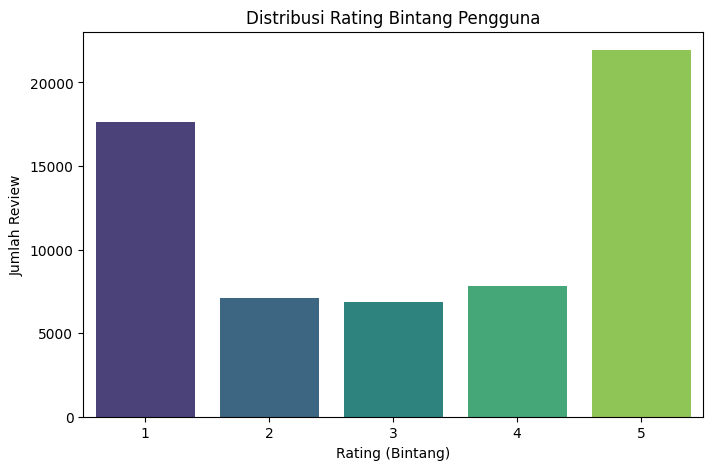


Word Cloud dari Review (Sebelum Cleaning):


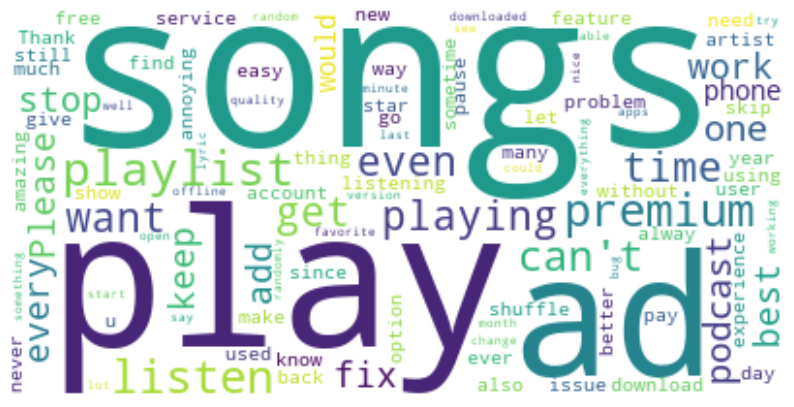

In [5]:
from nltk.corpus import stopwords

# 1. Jumlah baris data & 4. Cek data kosong
print("--- Info Data Awal ---")
df.info()
print("\n--- Cek Data Kosong (NaN) ---")
print(df.isnull().sum())

# Hapus baris yang review-nya kosong
df.dropna(subset=['Review'], inplace=True)
print(f"\nJumlah baris setelah drop NaN di 'Review': {df.shape[0]}")

# 3. Cek data duplikasi
print(f"\nJumlah review yang duplikat: {df.duplicated(subset=['Review']).sum()}")
df.drop_duplicates(subset=['Review'], inplace=True, keep='first')
print(f"Jumlah baris setelah drop duplikat: {df.shape[0]}")

# 5. Distribusi data (rating)
plt.figure(figsize=(8, 5))
sns.countplot(x='Rating', data=df, palette='viridis', order=[1, 2, 3, 4, 5])
plt.title('Distribusi Rating Bintang Pengguna')
plt.xlabel('Rating (Bintang)')
plt.ylabel('Jumlah Review')
plt.show()

# 5. Word cloud (PAKE 'R' BESAR)
print("\nWord Cloud dari Review (Sebelum Cleaning):")
text = " ".join(review for review in df.Review.astype(str)) # GANTI DI SINI
stop_words_wc = set(stopwords.words('english')) # Baris ini sekarang aman
stop_words_wc.update(['app', 'spotify', 'music', 'song', 'good', 'great', 'like', 'love', 'really', 'use', 'app', 'update'])

wordcloud = WordCloud(stopwords=stop_words_wc, background_color="white", max_words=100, collocations=False).generate(text)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Data Text Processing

In [6]:
import re # Pastikan 're' (Regular Expression) sudah di-import

# 1. Tokenisasi - DILOMPATI (Akan dikerjakan otomatis oleh model)
# 2. Lemmatization - DILOMPATI (Tidak perlu untuk model RoBERTa)
# 3. Stemming - DILOMPATI (Tidak perlu untuk model RoBERTa)
# 4. Stopword removal - DILOMPATI (Tidak perlu untuk model RoBERTa)

# 5. Text Normalisasi
# Kita hanya lakukan cleaning dasar: lowercase, hapus URL, dan hapus karakter aneh.
def clean_text(text):
    text = str(text).lower()  # 5. Normalisasi (Lowercase)
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE) # 4. Hapus URL
    text = re.sub(r'[^a-zA-Z0-9\s.,!?\'\"]', '', text) # 4. Hapus karakter aneh (sisakan yg penting)
    text = re.sub(r'\s+', ' ', text).strip() # Hapus spasi berlebih
    return text

print("Melakukan cleaning teks dasar...")
# Pastikan pakai 'Review' (R besar)
df['clean_review'] = df['Review'].apply(clean_text)
print("Cleaning selesai.")

# 7. Labeling data
# Tidak perlu diubah. Kita akan pakai kolom 'Rating' (R besar) sebagai pembanding nanti.
    
# 8. Text Vektorisasi & 9. Data splitting
# Tidak perlu di tahap ini. Akan di-handle otomatis oleh pipeline Hugging Face
# saat kita melakukan prediksi (inferensi).

print("\nContoh Teks Setelah Cleaning:")
# Pastikan pakai 'Review' dan 'Rating' (R besar)
display(df[['Review', 'clean_review', 'Rating']].head())

Melakukan cleaning teks dasar...
Cleaning selesai.

Contoh Teks Setelah Cleaning:


,Review,clean_review,Rating
0,"Great music service, the audio is high quality...","great music service, the audio is high quality...",5
1,Please ignore previous negative rating. This a...,please ignore previous negative rating. this a...,5
2,"This pop-up ""Get the best Spotify experience o...","this popup ""get the best spotify experience on...",4
3,Really buggy and terrible to use as of recently,really buggy and terrible to use as of recently,1
4,Dear Spotify why do I get songs that I didn't ...,dear spotify why do i get songs that i didn't ...,1


## Data Modeling

In [7]:
# Berikan Penjelasan tentang model yang dipilih
# Model yang digunakan adalah Deep Learning (Neural Network) dari arsitektur Transformer,
# yaitu "SamLowe/roberta-base-go_emotions".
#
# Ini adalah model RoBERTa yang sudah di-finetuning (pre-trained) pada dataset GoEmotions
# dan mampu mengklasifikasikan teks ke dalam 28 kategori emosi yang berbeda,
# seperti 'joy', 'sadness', 'anger', 'love', 'admiration', dll.
#
# Kita tidak akan melatih model (training) dari nol, tapi langsung menggunakannya (inferencing)
# untuk menganalisis data review kita. Ini jauh lebih canggih dari SVM/Naive Bayes
# karena bisa menangkap konteks kalimat dengan lebih baik.

from transformers import pipeline
import torch
import pandas as pd

# Load pipeline classifier dari Hugging Face
print("Loading model 'SamLowe/roberta-base-go_emotions'...")
emotion_classifier = pipeline(
    "text-classification", 
    model="SamLowe/roberta-base-go_emotions", 
    return_all_scores=True 
)
print("Model berhasil di-load.")

# --- Tes model pada satu review ---
contoh_review = "This app is absolutely amazing, I use it everyday! Love the recommendations."
print(f"\n--- Hasil Tes Model ---")
print(f"Review: '{contoh_review}'")

try:
    hasil_emosi = emotion_classifier(contoh_review)
    
    # Tampilkan hasil dalam DataFrame biar rapi
    hasil_df = pd.DataFrame(hasil_emosi[0]).sort_values(by='score', ascending=False)
    print(f"5 Emosi Teratas yang Terdeteksi:")
    display(hasil_df.head(5))

except Exception as e:
    print(f"Terjadi error saat prediksi: {e}")

Loading model 'SamLowe/roberta-base-go_emotions'...


Device set to use cpu
c:\Users\DELL\miniconda3\envs\tensor\lib\site-packages\transformers\pipelines\text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


Model berhasil di-load.

--- Hasil Tes Model ---
Review: 'This app is absolutely amazing, I use it everyday! Love the recommendations.'
5 Emosi Teratas yang Terdeteksi:


,label,score
0,admiration,0.853389
18,love,0.709360
4,approval,0.025760
17,joy,0.021696
15,gratitude,0.009281


## Data Evaluasi

Menganalisis emosi pada 500 review acak... (Proses ini butuh waktu...)
Analisis emosi selesai.

--- Visualisasi Distribusi Emosi ---


C:\Users\DELL\AppData\Local\Temp\ipykernel_15872\3363613062.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=emotion_counts.values, y=emotion_counts.index, orient='h', palette='magma')


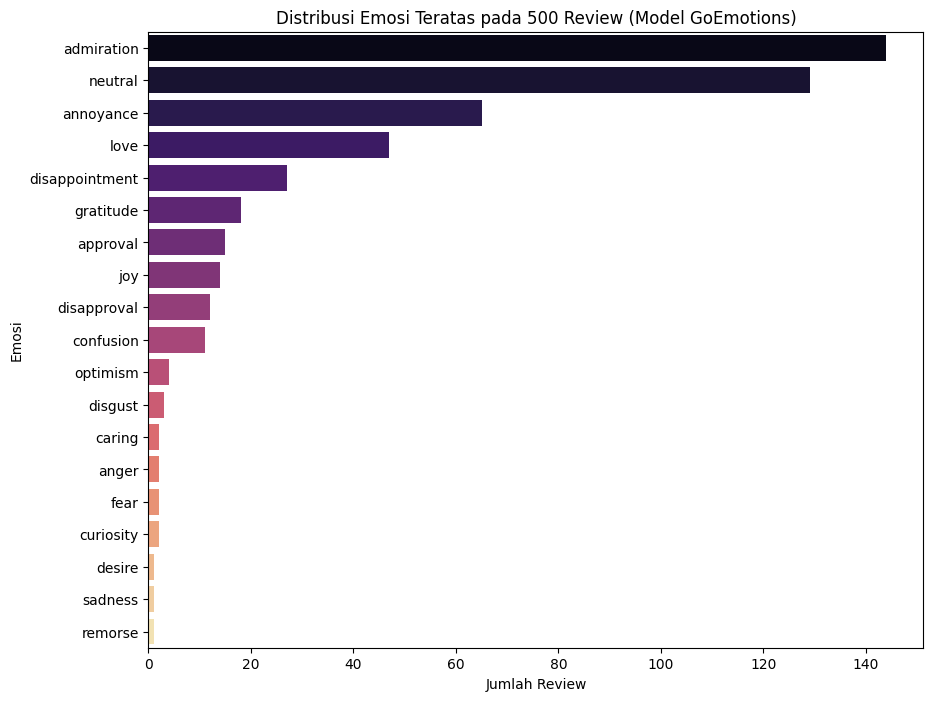


--- Visualisasi Perbandingan Emosi vs Rating Bintang ---


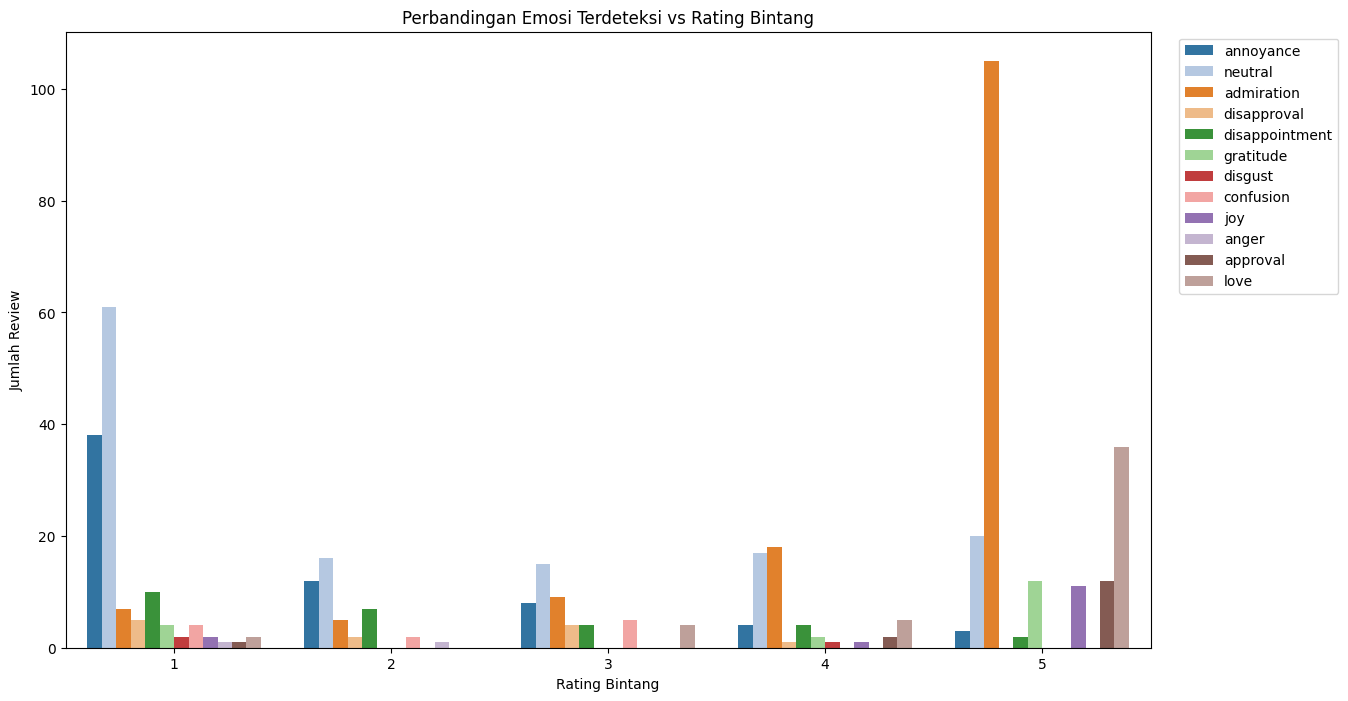

In [8]:
# 1. Confussion Matrix & 2. Laporan Klasifikasi
# Karena dataset kita (reviews.csv) tidak memiliki "kunci jawaban" (ground truth)
# untuk 28 label emosi, kita tidak bisa membuat Confusion Matrix
# atau Classification Report secara langsung.
#
# SEBAGAI GANTINYA, kita akan melakukan evaluasi kualitatif:
# 1. Menerapkan model ke sampel data (misal 500 review acak).
# 2. Memvisualisasikan distribusi emosi yang ditemukan.
# 3. Membandingkan distribusi emosi tersebut dengan 'Rating' bintang yang ada.

# Fungsi untuk mendapatkan emosi teratas dari review
def get_top_emotion(review):
    if pd.isna(review) or review.strip() == "":
        return 'neutral' # Anggap netral jika review kosong
    try:
        # Model RoBERTa punya batas token (512), jadi kita potong
        review_terpotong = str(review)[:510] 
        
        results = emotion_classifier(review_terpotong)
        # Ambil label dengan skor tertinggi
        top_emotion = sorted(results[0], key=lambda x: x['score'], reverse=True)[0]
        
        # Kita ambil emosi teratas, ATAU 'neutral' jika skornya terlalu rendah
        if top_emotion['score'] > 0.3: # Threshold 0.3 (bisa diatur)
            return top_emotion['label']
        else:
            return 'neutral'
    except Exception as e:
        print(f"Error pada review: {e}")
        return 'error'

# --- Menerapkan Model ke Sampel Data ---
# Menerapkan ke 100rb+ data akan sangat LAMA (bisa berjam-jam).
# Untuk tugas ini, kita ambil sampel acak 500 data saja agar cepat.
df_sample = df.sample(500, random_state=42).copy()

print(f"Menganalisis emosi pada {len(df_sample)} review acak... (Proses ini butuh waktu...)")
# Pastikan pakai 'clean_review' (teks bersih)
df_sample['emotion'] = df_sample['clean_review'].apply(get_top_emotion)
print("Analisis emosi selesai.")

# --- Visualisasi Hasil (Pengganti Evaluasi) ---

# 1. Distribusi Total Emosi yang Ditemukan
print("\n--- Visualisasi Distribusi Emosi ---")
plt.figure(figsize=(10, 8))
emotion_counts = df_sample['emotion'].value_counts()
sns.barplot(x=emotion_counts.values, y=emotion_counts.index, orient='h', palette='magma')
plt.title(f'Distribusi Emosi Teratas pada {len(df_sample)} Review (Model GoEmotions)')
plt.xlabel('Jumlah Review')
plt.ylabel('Emosi')
plt.show()

# 2. Perbandingan Emosi vs Rating Bintang (Ini Keren!)
print("\n--- Visualisasi Perbandingan Emosi vs Rating Bintang ---")
# Kita fokus pada emosi utama saja (misal 10 terbanyak) + emosi negatif
top_emotions = emotion_counts.head(10).index.tolist()
if 'anger' not in top_emotions: top_emotions.append('anger')
if 'disappointment' not in top_emotions: top_emotions.append('disappointment')
if 'disgust' not in top_emotions: top_emotions.append('disgust')
if 'joy' not in top_emotions: top_emotions.append('joy')

df_plot = df_sample[df_sample['emotion'].isin(top_emotions)]

plt.figure(figsize=(14, 8))
# Pastikan pakai 'Rating' (R besar)
sns.countplot(x='Rating', data=df_plot, hue='emotion', palette='tab20', order=[1, 2, 3, 4, 5])
plt.title('Perbandingan Emosi Terdeteksi vs Rating Bintang')
plt.xlabel('Rating Bintang')
plt.ylabel('Jumlah Review')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
plt.show()

## Data Prediksi

In [10]:
# Gunakan model yang sudah dibuat (emotion_classifier) untuk prediksi data baru
import pandas as pd # Import ulang pandas untuk jaga-jaga
import re # Import ulang re
import time

# Definisikan ulang fungsi clean_text jika error (biar aman)
try:
    clean_text("test")
except NameError:
    print("Mendefinisikan ulang clean_text...")
    def clean_text(text):
        text = str(text).lower()
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE) 
        text = re.sub(r'[^a-zA-Z0-9\s.,!?\'\"]', '', text) 
        text = re.sub(r'\s+', ' ', text).strip()
        return text

print("--- Memulai Prediksi 28 Emosi ---")

# Daftar 28 emosi dari model SamLowe/roberta-base-go_emotions
# Kita buat 28 review yang nargetin tiap emosi
emotion_reviews = {
    "admiration": "This Spotify playlist is curated by a genius. The transitions are flawless.",
    "amusement": "Lol, my Spotify 'On Repeat' is just 10 versions of the same meme song.",
    "anger": "I HATE this update! You moved the button I use every single day!",
    "annoyance": "Why does this ad keep playing? It's the 5th time in an hour. So annoying.",
    "approval": "Good update. The new search function works much better now.",
    "caring": "Spotify sent me a 'wellness' playlist... honestly, it felt nice. Like they care.",
    "confusion": "I have no idea how this new interface is supposed to work. Where is my library?",
    "curiosity": "Ooh, what's this 'Blend' feature? I'm curious to see what my friend listens to.",
    "desire": "I really, really want Spotify HiFi. I need that lossless audio quality.",
    "disappointment": "Waited 3 years for Spotify HiFi and... nothing. What a disappointment.",
    "disapproval": "They really shouldn't promote this kind of hateful music on the front page.",
    "disgust": "Ugh, this podcast is just disgusting. The host is so crude.",
    "embarrassment": "My friend saw my 'Guilty Pleasures' playlist... I'm so embarrassed.",
    "excitement": "My favorite band just dropped a new album! Can't wait to listen!",
    "fear": "I'm afraid my account was hacked. The password isn't working.",
    "gratitude": "Thank you Spotify for making my long commute so much better every day.",
    "grief": "Listening to this song... it just brings back all the grief. I miss him.",
    "joy": "Found an old playlist from college. Pure joy and nostalgia!",
    "love": "I absolutely love Spotify. It's the best app I have on my phone.",
    "nervousness": "I'm nervous about presenting my playlist to the class...",
    "optimism": "The new update looks promising. I'm optimistic they'll fix the bugs soon.",
    "pride": "Check out my 2025 Spotify Wrapped. 100,000 minutes! I feel so proud.",
    "realization": "Wow... I just realized I've listened to nothing but sad songs all month.",
    "relief": "Phew, my subscription finally renewed. I thought I lost my downloads. What a relief.",
    "remorse": "I probably shouldn't have made that mean playlist about my ex... I feel bad now.",
    "sadness": "This playlist is perfect for a rainy day. Just pure sadness and melancholy.",
    "surprise": "Whoa! I did not expect that song to be in my 'Discover Weekly'. What a surprise!",
    "neutral": "This is a music streaming application."
}

# Loop dan prediksi setiap review
for emotion, review in emotion_reviews.items():
    print("\n" + "="*40)
    print(f"TARGET EMOSI: {emotion.upper()}")
    print(f"Review: \"{review}\"")
    
    clean_review = clean_text(review)
    
    try:
        start_time = time.time()
        hasil_prediksi = emotion_classifier(clean_review)
        end_time = time.time()
        
        # Tampilkan SEMUA 28 SKOR, diurutkan dari yang tertinggi
        hasil_df = pd.DataFrame(hasil_prediksi[0]).sort_values(by='score', ascending=False)
        
        print(f"Prediksi Emosi (Skor 0-1) - Selesai dalam {end_time - start_time:.2f} dtk:")
        
        # Tampilkan semua baris DataFrame (28 emosi)
        with pd.option_context('display.max_rows', None):
            display(hasil_df)
        
    except NameError:
        print("ERROR: Model 'emotion_classifier' tidak ditemukan. Jalankan ulang Cell 8.")
        break
    except Exception as e:
        print(f"Terjadi error saat prediksi: {e}")

print("\n" + "="*40)
print("--- Prediksi 28 Emosi Selesai ---")

--- Memulai Prediksi 28 Emosi ---

TARGET EMOSI: ADMIRATION
Review: "This Spotify playlist is curated by a genius. The transitions are flawless."
Prediksi Emosi (Skor 0-1) - Selesai dalam 0.11 dtk:


,label,score
0,admiration,0.890060
4,approval,0.142979
27,neutral,0.078113
3,annoyance,0.012257
10,disapproval,0.011994
22,realization,0.011351
15,gratitude,0.008198
20,optimism,0.007216
21,pride,0.005679
9,disappointment,0.005552



TARGET EMOSI: AMUSEMENT
Review: "Lol, my Spotify 'On Repeat' is just 10 versions of the same meme song."
Prediksi Emosi (Skor 0-1) - Selesai dalam 0.26 dtk:


,label,score
1,amusement,0.907254
17,joy,0.050256
27,neutral,0.042523
22,realization,0.012279
4,approval,0.012246
0,admiration,0.007229
3,annoyance,0.006064
18,love,0.005066
20,optimism,0.003851
10,disapproval,0.002760



TARGET EMOSI: ANGER
Review: "I HATE this update! You moved the button I use every single day!"
Prediksi Emosi (Skor 0-1) - Selesai dalam 0.17 dtk:


,label,score
2,anger,0.777632
3,annoyance,0.252285
27,neutral,0.055555
10,disapproval,0.055143
11,disgust,0.025658
9,disappointment,0.013413
25,sadness,0.009091
4,approval,0.006523
22,realization,0.004144
6,confusion,0.003912



TARGET EMOSI: ANNOYANCE
Review: "Why does this ad keep playing? It's the 5th time in an hour. So annoying."
Prediksi Emosi (Skor 0-1) - Selesai dalam 0.09 dtk:


,label,score
3,annoyance,0.745860
2,anger,0.116494
7,curiosity,0.073109
9,disappointment,0.061116
27,neutral,0.055836
6,confusion,0.034944
10,disapproval,0.030601
11,disgust,0.019654
4,approval,0.012919
22,realization,0.010785



TARGET EMOSI: APPROVAL
Review: "Good update. The new search function works much better now."
Prediksi Emosi (Skor 0-1) - Selesai dalam 0.13 dtk:


,label,score
0,admiration,0.870235
4,approval,0.176934
17,joy,0.044783
15,gratitude,0.027255
27,neutral,0.021690
13,excitement,0.019032
21,pride,0.012693
20,optimism,0.012544
22,realization,0.012112
23,relief,0.005896



TARGET EMOSI: CARING
Review: "Spotify sent me a 'wellness' playlist... honestly, it felt nice. Like they care."
Prediksi Emosi (Skor 0-1) - Selesai dalam 0.18 dtk:


,label,score
5,caring,0.482162
0,admiration,0.388561
4,approval,0.271061
17,joy,0.130049
27,neutral,0.053934
18,love,0.040641
23,relief,0.033580
15,gratitude,0.019778
20,optimism,0.019115
21,pride,0.011756



TARGET EMOSI: CONFUSION
Review: "I have no idea how this new interface is supposed to work. Where is my library?"
Prediksi Emosi (Skor 0-1) - Selesai dalam 0.08 dtk:


,label,score
6,confusion,0.933197
7,curiosity,0.145698
27,neutral,0.070770
3,annoyance,0.020886
10,disapproval,0.016803
22,realization,0.014882
4,approval,0.012772
9,disappointment,0.012752
26,surprise,0.010874
18,love,0.007857



TARGET EMOSI: CURIOSITY
Review: "Ooh, what's this 'Blend' feature? I'm curious to see what my friend listens to."
Prediksi Emosi (Skor 0-1) - Selesai dalam 0.20 dtk:


,label,score
7,curiosity,0.907917
27,neutral,0.074646
6,confusion,0.048188
13,excitement,0.018924
4,approval,0.016231
0,admiration,0.015273
18,love,0.011460
8,desire,0.008459
5,caring,0.007942
20,optimism,0.007588



TARGET EMOSI: DESIRE
Review: "I really, really want Spotify HiFi. I need that lossless audio quality."
Prediksi Emosi (Skor 0-1) - Selesai dalam 0.10 dtk:


,label,score
8,desire,0.778314
27,neutral,0.157872
3,annoyance,0.023448
4,approval,0.021095
20,optimism,0.017425
7,curiosity,0.013750
9,disappointment,0.013022
11,disgust,0.007971
0,admiration,0.007511
25,sadness,0.007255



TARGET EMOSI: DISAPPOINTMENT
Review: "Waited 3 years for Spotify HiFi and... nothing. What a disappointment."
Prediksi Emosi (Skor 0-1) - Selesai dalam 0.23 dtk:


,label,score
9,disappointment,0.855807
3,annoyance,0.122752
27,neutral,0.070666
25,sadness,0.070175
10,disapproval,0.066082
22,realization,0.015172
2,anger,0.011689
12,embarrassment,0.011166
26,surprise,0.010617
20,optimism,0.009690



TARGET EMOSI: DISAPPROVAL
Review: "They really shouldn't promote this kind of hateful music on the front page."
Prediksi Emosi (Skor 0-1) - Selesai dalam 0.13 dtk:


,label,score
10,disapproval,0.550098
27,neutral,0.202527
3,annoyance,0.195075
2,anger,0.098812
4,approval,0.024495
11,disgust,0.012675
9,disappointment,0.010026
22,realization,0.009850
5,caring,0.005674
25,sadness,0.003671



TARGET EMOSI: DISGUST
Review: "Ugh, this podcast is just disgusting. The host is so crude."
Prediksi Emosi (Skor 0-1) - Selesai dalam 0.29 dtk:


,label,score
11,disgust,0.846020
3,annoyance,0.067557
10,disapproval,0.032860
4,approval,0.024919
18,love,0.021328
27,neutral,0.020853
9,disappointment,0.018706
2,anger,0.018495
1,amusement,0.015756
0,admiration,0.015716



TARGET EMOSI: EMBARRASSMENT
Review: "My friend saw my 'Guilty Pleasures' playlist... I'm so embarrassed."
Prediksi Emosi (Skor 0-1) - Selesai dalam 0.18 dtk:


,label,score
12,embarrassment,0.788601
24,remorse,0.067146
9,disappointment,0.050087
27,neutral,0.042611
3,annoyance,0.037475
22,realization,0.032561
11,disgust,0.028920
1,amusement,0.027135
25,sadness,0.025974
26,surprise,0.021659



TARGET EMOSI: EXCITEMENT
Review: "My favorite band just dropped a new album! Can't wait to listen!"
Prediksi Emosi (Skor 0-1) - Selesai dalam 0.26 dtk:


,label,score
13,excitement,0.743838
17,joy,0.055469
18,love,0.050518
7,curiosity,0.042945
27,neutral,0.040303
0,admiration,0.039134
26,surprise,0.023347
4,approval,0.018584
8,desire,0.007673
6,confusion,0.006456



TARGET EMOSI: FEAR
Review: "I'm afraid my account was hacked. The password isn't working."
Prediksi Emosi (Skor 0-1) - Selesai dalam 0.13 dtk:


,label,score
14,fear,0.884740
19,nervousness,0.104205
27,neutral,0.044063
25,sadness,0.024816
22,realization,0.021875
4,approval,0.015854
9,disappointment,0.014790
10,disapproval,0.014324
3,annoyance,0.011370
5,caring,0.011022



TARGET EMOSI: GRATITUDE
Review: "Thank you Spotify for making my long commute so much better every day."
Prediksi Emosi (Skor 0-1) - Selesai dalam 0.13 dtk:


,label,score
15,gratitude,0.989453
0,admiration,0.052708
4,approval,0.022200
17,joy,0.007822
27,neutral,0.006259
22,realization,0.005758
20,optimism,0.005677
3,annoyance,0.004114
13,excitement,0.004091
23,relief,0.003295



TARGET EMOSI: GRIEF
Review: "Listening to this song... it just brings back all the grief. I miss him."
Prediksi Emosi (Skor 0-1) - Selesai dalam 0.62 dtk:


,label,score
25,sadness,0.913414
9,disappointment,0.088677
16,grief,0.038818
18,love,0.026517
27,neutral,0.022378
22,realization,0.015452
24,remorse,0.014260
0,admiration,0.013472
3,annoyance,0.012887
4,approval,0.010677



TARGET EMOSI: JOY
Review: "Found an old playlist from college. Pure joy and nostalgia!"
Prediksi Emosi (Skor 0-1) - Selesai dalam 0.16 dtk:


,label,score
17,joy,0.798668
13,excitement,0.177385
27,neutral,0.035796
1,amusement,0.027269
4,approval,0.025533
0,admiration,0.018997
22,realization,0.015756
23,relief,0.015608
18,love,0.011766
26,surprise,0.008024



TARGET EMOSI: LOVE
Review: "I absolutely love Spotify. It's the best app I have on my phone."
Prediksi Emosi (Skor 0-1) - Selesai dalam 0.11 dtk:


,label,score
18,love,0.859222
0,admiration,0.588771
4,approval,0.035647
17,joy,0.014502
15,gratitude,0.010766
27,neutral,0.007667
20,optimism,0.006721
10,disapproval,0.005396
22,realization,0.004867
13,excitement,0.003897



TARGET EMOSI: NERVOUSNESS
Review: "I'm nervous about presenting my playlist to the class..."
Prediksi Emosi (Skor 0-1) - Selesai dalam 0.18 dtk:


,label,score
19,nervousness,0.595517
14,fear,0.174999
27,neutral,0.093226
5,caring,0.057495
13,excitement,0.057338
25,sadness,0.048209
6,confusion,0.044652
17,joy,0.032964
4,approval,0.029703
22,realization,0.027669



TARGET EMOSI: OPTIMISM
Review: "The new update looks promising. I'm optimistic they'll fix the bugs soon."
Prediksi Emosi (Skor 0-1) - Selesai dalam 0.13 dtk:


,label,score
20,optimism,0.932798
5,caring,0.069349
8,desire,0.054105
27,neutral,0.052304
4,approval,0.045403
0,admiration,0.028765
15,gratitude,0.012217
10,disapproval,0.006842
18,love,0.006176
22,realization,0.005864



TARGET EMOSI: PRIDE
Review: "Check out my 2025 Spotify Wrapped. 100,000 minutes! I feel so proud."
Prediksi Emosi (Skor 0-1) - Selesai dalam 0.15 dtk:


,label,score
21,pride,0.412609
0,admiration,0.410267
17,joy,0.112456
27,neutral,0.105066
13,excitement,0.097082
4,approval,0.079872
22,realization,0.045612
23,relief,0.045468
15,gratitude,0.021813
26,surprise,0.020803



TARGET EMOSI: REALIZATION
Review: "Wow... I just realized I've listened to nothing but sad songs all month."
Prediksi Emosi (Skor 0-1) - Selesai dalam 0.12 dtk:


,label,score
22,realization,0.721071
26,surprise,0.126871
25,sadness,0.117777
1,amusement,0.070145
9,disappointment,0.065276
12,embarrassment,0.042734
27,neutral,0.024871
24,remorse,0.022250
17,joy,0.021941
4,approval,0.016716



TARGET EMOSI: RELIEF
Review: "Phew, my subscription finally renewed. I thought I lost my downloads. What a relief."
Prediksi Emosi (Skor 0-1) - Selesai dalam 0.14 dtk:


,label,score
17,joy,0.557684
23,relief,0.359426
4,approval,0.123385
27,neutral,0.075843
22,realization,0.072416
25,sadness,0.053997
5,caring,0.053684
9,disappointment,0.034529
15,gratitude,0.033823
21,pride,0.022957



TARGET EMOSI: REMORSE
Review: "I probably shouldn't have made that mean playlist about my ex... I feel bad now."
Prediksi Emosi (Skor 0-1) - Selesai dalam 0.24 dtk:


,label,score
25,sadness,0.557925
9,disappointment,0.368698
24,remorse,0.045447
3,annoyance,0.035820
27,neutral,0.025903
22,realization,0.025328
10,disapproval,0.025245
12,embarrassment,0.011758
4,approval,0.008571
19,nervousness,0.005967



TARGET EMOSI: SADNESS
Review: "This playlist is perfect for a rainy day. Just pure sadness and melancholy."
Prediksi Emosi (Skor 0-1) - Selesai dalam 0.13 dtk:


,label,score
25,sadness,0.713174
0,admiration,0.207049
9,disappointment,0.092905
18,love,0.058698
4,approval,0.055778
16,grief,0.019304
27,neutral,0.016933
22,realization,0.016193
17,joy,0.014930
5,caring,0.014819



TARGET EMOSI: SURPRISE
Review: "Whoa! I did not expect that song to be in my 'Discover Weekly'. What a surprise!"
Prediksi Emosi (Skor 0-1) - Selesai dalam 0.15 dtk:


,label,score
26,surprise,0.869806
13,excitement,0.063135
27,neutral,0.038306
22,realization,0.030286
7,curiosity,0.019567
0,admiration,0.018683
20,optimism,0.016263
17,joy,0.011566
9,disappointment,0.009313
1,amusement,0.008871



TARGET EMOSI: NEUTRAL
Review: "This is a music streaming application."
Prediksi Emosi (Skor 0-1) - Selesai dalam 0.14 dtk:


,label,score
27,neutral,0.931744
4,approval,0.036552
22,realization,0.012426
3,annoyance,0.011489
10,disapproval,0.008306
0,admiration,0.003279
9,disappointment,0.002739
2,anger,0.001735
6,confusion,0.001709
11,disgust,0.001639



--- Prediksi 28 Emosi Selesai ---
